In [1]:
import torchtext.data as data
from torchtext.data import BucketIterator
import torch
from torch.distributions import Categorical
#from torch import nn
from torch_struct import HMM
#import matplotlib
import matplotlib.pyplot as plt

In [2]:
class ConllXDataset(data.Dataset):
    def __init__(self, path, fields, encoding='utf-8', separator='\t', **kwargs):
        examples = []
        columns = [[], []]
        column_map = {1: 0, 3: 1}
        with open(path, encoding=encoding) as input_file:
            for line in input_file:
                line = line.strip()
                if line == '':
                    examples.append(data.Example.fromlist(columns, fields))
                    columns = [[], []]
                else:
                    for i, column in enumerate(line.split(separator)):
                        if i in column_map:
                            columns[column_map[i]].append(column)
            examples.append(data.Example.fromlist(columns, fields))
        super(ConllXDataset, self).__init__(examples, fields, **kwargs)

In [3]:
WORD = data.Field(pad_token=None)
POS = data.Field(include_lengths=True, pad_token=None) # init_token='<bos>'
fields = (('word', WORD), ('pos', POS), (None, None))

train = ConllXDataset('samIam.conllu', fields)
train_DATA = ConllXDataset('samIam-dataCopies.conllu', fields)
test = ConllXDataset('test.conllu', fields)

WORD.build_vocab(train_DATA) # include 'was' in vocab with <unk> as it's POS
POS.build_vocab(train_DATA)
print(WORD.vocab.stoi)
print(POS.vocab.stoi)

#to do: store parameters in model class, embeddings
train_iter = BucketIterator(train, batch_size=2, device='cpu', shuffle=False)
train_iter_DATA = BucketIterator(train_DATA, batch_size=2, device='cpu', shuffle=False)

test_iter = BucketIterator(test, batch_size=2, device='cpu', shuffle=False)

C = len(POS.vocab)
V = len(WORD.vocab)
print('C', C, 'V', V)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x11ff25b90>>, {'<unk>': 0, 'I': 1, '·': 2, 'am': 3, 'Sam': 4, 'Am': 5, 'was': 6})
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x11ff25c10>>, {'<unk>': 0, 'PRON': 1, 'PUNCT': 2, 'AUX': 3, 'PROPN': 4})
C 5 V 7


In [4]:
class Model():
    def __init__(self):
        super().__init__()
        self.trnsn_prms = {}
        self.emssn_prms = {}

    def update_a(self, tag_sq, length):
        for i, x in enumerate(tag_sq[:length]): 
            # print(POS.vocab.itos[x.item()])
            if i!=0: 
                if (tag_sq[i-1].item(), x.item()) not in self.trnsn_prms:
                    self.trnsn_prms[(tag_sq[i-1].item(), x.item())] = 1
                elif (tag_sq[i-1].item(), x.item()) in self.trnsn_prms:
                    self.trnsn_prms[(tag_sq[i-1].item(), x.item())] += 1

    def update_b(self, tag_sq, sent, length):
        for i, t in enumerate(tag_sq[:length]): 
            x = (t.item(), sent[i].item())
            if x not in self.emssn_prms:
                self.emssn_prms[x] = 1
            elif x in self.emssn_prms:
                self.emssn_prms[x] += 1

In [5]:
def show_chain(chain):
    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

In [12]:
def trn(train_iter, model):
    for ex in train_iter:
        words = ex.word
        label, lengths = ex.pos
        # for x in range(words.shape[1]):
            # print(' '.join([WORD.vocab.itos[i] for i in words[:, x]]))
            # print(' '.join([POS.vocab.itos[i] for i in label[:, x]]))

        for b in range(label.shape[1]):
            model.update_a(label[:, b], lengths[b])
            model.update_b(label[:, b], words[:, b], lengths[b])
    # print(model.trnsn_prms)
    # print([(POS.vocab.itos[x[0]], POS.vocab.itos[x[1]], model.trnsn_prms[x]) for x in model.trnsn_prms])
    # print([(POS.vocab.itos[x[0]], WORD.vocab.itos[x[1]], model.emssn_prms[x]) for x in model.emssn_prms])

    transition = torch.zeros((C, C)) 
    for x in model.trnsn_prms:
        transition[x[0], x[1]] = model.trnsn_prms[x] # populate with counts: (pos_n-1, pos_n)
    #print(transition)
    for row in range(transition.shape[0]):
        if row!=POS.vocab.stoi['PUNCT']: # 0-probs at p(z_n | z_n-1 = punct) 
            transition[row, :] = Categorical(transition[row, :]).probs # normalize counts
    #print(transition.shape, '\n', transition)
    transition = transition.transpose(0, 1) # p(z_n| z_n-1) 
    print('transition', '\n', transition)

    init = torch.zeros(C)
    for x in range(C):
        init[x] = POS.vocab.freqs[POS.vocab.itos[x]]
    #print(init)
    init = Categorical(init).probs
    #print(init)
   
    emission = torch.zeros((C, V)) 
    for x in model.emssn_prms:  
        emission[x[0], x[1]] = model.emssn_prms[x]
    #print(emission)
    for row in range(emission.shape[0]):
        emission[row, :] = Categorical(emission[row, :]).probs # p(w_i = ·|PUNCT) = 1, (Eisenstein: 148)
    #print(emission)
    emission = emission.transpose(0,1) # p(x_n| z_n)
    print('emission', '\n', emission)

    for ex in train_iter:
        label, lengths = ex.pos
        observations = torch.LongTensor(ex.word).transpose(0, 1).contiguous()

        dist = HMM(transition, emission, init, observations, lengths=lengths) # CxC, VxC, C, bxN -> b x (N-1) x C x C 
        # print('train')

        print('label train', label.transpose(0, 1)[0])

        # print('marginals', dist.marginals[0].sum(-1))
        # print('argmax', dist.argmax[0].sum(-1))
        # print(dist.argmax.shape) # 
        
        show_chain(dist.argmax[0])
        plt.show()

    for i, ex in enumerate(test_iter):
        label, lengths = ex.pos
        #print(label.shape)
        observations = torch.LongTensor(ex.word).transpose(0, 1).contiguous()

        #print('words', observations[0])
        print('label test', i, label.transpose(0, 1)[0])

        dist = HMM(transition, emission, init, observations, lengths=lengths) # CxC, VxC, C, bxN
        #print(dist.log_potentials[0].sum(-1))   

        print(dist.marginals[0].sum(-1))     
        print(dist.argmax[0].sum(-1))        

        show_chain(dist.argmax[0])
        plt.show()

transition 
 tensor([[0.0000, 0.0000, 0.0000, 0.1429, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.2857, 0.2500],
        [0.5000, 0.1429, 0.0000, 0.4286, 0.5000],
        [0.0000, 0.7143, 0.0000, 0.0000, 0.2500],
        [0.0000, 0.1429, 0.0000, 0.1429, 0.0000]])
emission 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8571, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.1429, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
label train tensor([4, 1, 3, 2])


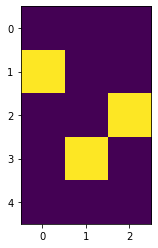

label train tensor([1, 3, 2, 0])


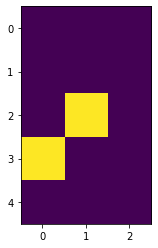

label train tensor([3, 1, 4, 2])


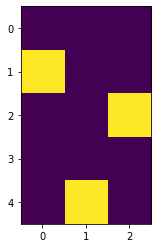

label train tensor([0, 1, 3, 2])


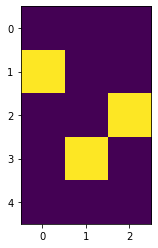

label test 0 tensor([4, 1, 3, 2])
tensor([[0.1277, 0.4383, 0.1471, 0.1576, 0.1293],
        [0.1845, 0.1922, 0.1738, 0.2552, 0.1942],
        [0.1240, 0.1484, 0.4503, 0.1497, 0.1276]], grad_fn=<SumBackward1>)
tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])


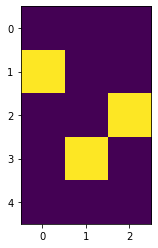

label test 1 tensor([0, 0, 0, 0, 2])
tensor([[0.3650, 0.1771, 0.1598, 0.1621, 0.1361],
        [0.3638, 0.1773, 0.1596, 0.1631, 0.1362],
        [0.3837, 0.1663, 0.1449, 0.1616, 0.1435],
        [0.1206, 0.1556, 0.4572, 0.1431, 0.1236]], grad_fn=<SumBackward1>)
tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])


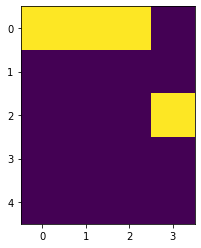

In [13]:
model = Model()
trn(train_iter, model)
# UNK PUNCT is observed once; p(w=unk| UNK) = 1
# probs/logits: p('was'| UNK/AUX) = 0 -> max p(z| Sam I was.) = PRON AUX PUNCT
# probs: max p(z| unk unk unk unk.) = UNK UNK UNK PUNCT
# logits: max p(z| unk unk unk unk.) = UNK PUNCT UNK PUNCT

data copies
transition 
 tensor([[0.0000, 0.0455, 0.0000, 0.0476, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.0952, 0.8421],
        [0.6667, 0.0455, 0.0000, 0.8095, 0.1053],
        [0.0000, 0.8636, 0.0000, 0.0000, 0.0526],
        [0.0000, 0.0455, 0.0000, 0.0476, 0.0000]])
emission 
 tensor([[0.6667, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9524, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0476, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.0000, 0.0000]])
label train tensor([4, 1, 3, 2])


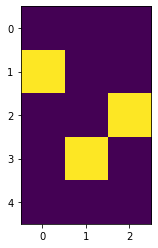

label train tensor([4, 1, 3, 2])


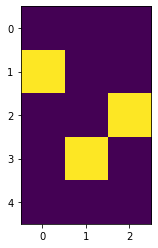

label train tensor([4, 1, 3, 2])


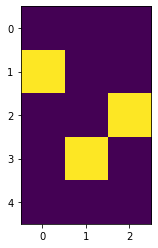

label train tensor([4, 1, 3, 2])


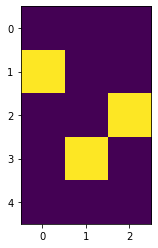

label train tensor([4, 1, 3, 2])


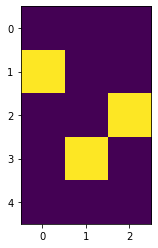

label train tensor([4, 1, 3, 2])


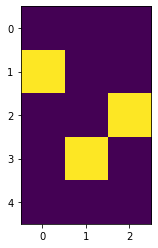

label train tensor([4, 1, 3, 2])


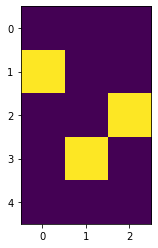

label train tensor([4, 1, 3, 2])


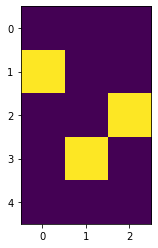

label train tensor([1, 3, 4, 2])


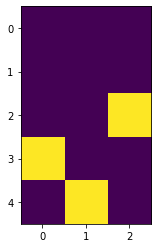

label train tensor([4, 3, 1, 2])


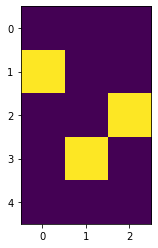

label train tensor([1, 3, 0, 2])


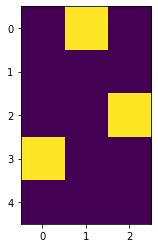

label test 0 tensor([4, 1, 3, 2])
tensor([[0.1095, 0.5190, 0.1222, 0.1348, 0.1145],
        [0.2373, 0.1711, 0.1505, 0.2938, 0.1473],
        [0.1159, 0.1493, 0.4762, 0.1427, 0.1159]], grad_fn=<SumBackward1>)
tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])


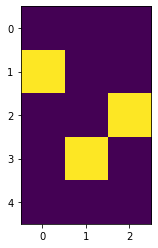

label test 1 tensor([0, 0, 0, 0, 2])
tensor([[0.2829, 0.2034, 0.1797, 0.1815, 0.1526],
        [0.2812, 0.2049, 0.1807, 0.1827, 0.1505],
        [0.3104, 0.1770, 0.1643, 0.2103, 0.1381],
        [0.1166, 0.1511, 0.4709, 0.1447, 0.1166]], grad_fn=<SumBackward1>)
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.]])


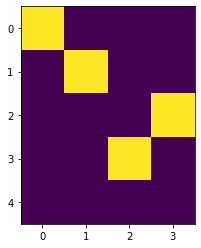

In [14]:
print('data copies') # ie repeat PRON AUX PUNCT
model1 = Model()
trn(train_iter_DATA, model1)
# UNK PUNCT is observed twice; p(w=unk| UNK) = 1
# probs: p('was'| UNK) = 0.3, p('was'| AUX) = 0 -> max p(z| Sam I was.) = PRON AUX PUNCT
# logits: p('was'| UNK) = 0.3, p('was'| AUX) = 0 -> max p(z| Sam I was.) = PRON UNK PUNCT
# probs: p(z| unk unk unk unk.) =  UNK PRON AUX PUNCT 
# logits: max p(z| unk unk unk unk.) = UNK PUNCT UNK PUNCT

In [ ]:
# y axis {'<unk>': 0, 'PRON': 1, 'PUNCT': 2, 'AUX': 3, 'PROPN': 4}